# TensorFlow Transfer Learning

This notebook shows how to use pre-trained models from [TensorFlowHub](https://www.tensorflow.org/hub). Sometimes, there is not enough data, computational resources, or time to train a model from scratch to solve a particular problem. We'll use a pre-trained model to classify flowers with better accuracy than a new model for use in a mobile application.

## Learning Objectives
1. Know how to apply image augmentation
2. Know how to download and use a TensorFlow Hub module as a layer in Keras.

In [1]:
import os
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub

## Exploring the data

As usual, let's take a look at the data before we start building our model. We'll be using a creative-commons licensed flower photo dataset of 3670 images falling into 5 categories: 'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'.

The below [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) command downloads a dataset to the local Keras cache. To see the files through a terminal, copy the output of the cell below.

In [2]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# Print data path
print("cd", data_dir)

cd /home/jupyter/.keras/datasets/flower_photos


We can use python's built in [pathlib](https://docs.python.org/3/library/pathlib.html) tool to get a sense of this unstructured data.

In [3]:
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("These are the available classes:", CLASS_NAMES)

There are 3670 images.
These are the available classes: ['roses' 'sunflowers' 'tulips' 'dandelion' 'daisy']


Let's display the images so we can see what our model will be trying to learn.

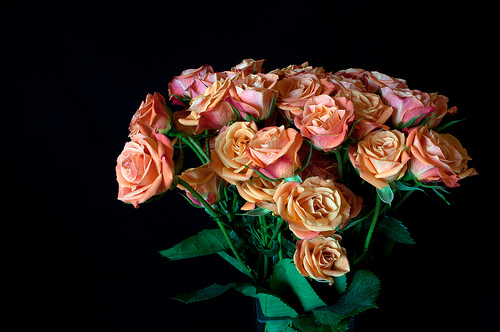

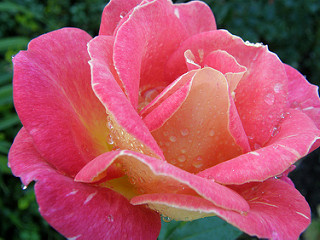

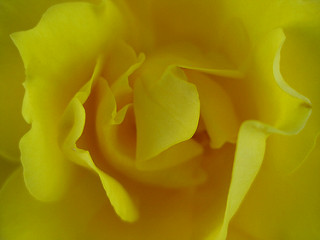

In [4]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Building the dataset

Keras has some convenient methods to read in image data. For instance [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is great for small local datasets. A tutorial on how to use it can be found [here](https://www.tensorflow.org/tutorials/load_data/images), but what if we have so many images, it doesn't fit on a local machine? We can use [tf.data.datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to build a generator based on files in a Google Cloud Storage Bucket.

We have already prepared these images to be stored on the cloud in `gs://cloud-ml-data/img/flower_photos/`. The images are randomly split into a training set with 90% data and an iterable with 10% data listed in CSV files:

Training set: [train_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/train_set.csv)  
Evaluation set: [eval_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/eval_set.csv)  

Explore the format and contents of the train.csv by running:

In [8]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv \
    | head -5 > /tmp/input.csv
!cat /tmp/input.csv

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [7]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | \
    sed 's/,/ /g' | awk '{print $2}' | sort | uniq > /tmp/labels.txt
!cat /tmp/labels.txt

daisy
dandelion
roses
sunflowers
tulips


Let's figure out how to read one of these images from the cloud. TensorFlow's [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file) can help us read the file contents, but the result will be a [Base64 image string](https://en.wikipedia.org/wiki/Base64). Hmm... not very readable for humans or Tensorflow.

Thankfully, TensorFlow's [tf.image.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg) function can decode this string into an integer array, and [tf.image.convert_image_dtype](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype) can cast it into a 0 - 1 range float. Finally, we'll use [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) to force image dimensions to be consistent for our neural network.

We'll wrap these into a function as we'll be calling these repeatedly. While we're at it, let's also define our constants for our neural network.

In [9]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 32
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [10]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

Is it working? Let's see!

**TODO 1.a:** Run the `decode_img` function and plot it to see a happy looking daisy.

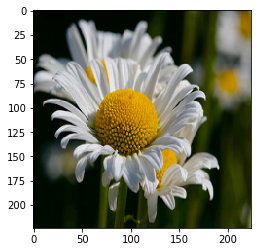

In [11]:
img = tf.io.read_file(
    "gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

# Uncomment to see the image string.
#print(img)
img = decode_img(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow((img.numpy()));

One flower down, 3669 more of them to go. Rather than load all the photos in directly, we'll use the file paths given to us in the csv and load the images when we batch. [tf.io.decode_csv](https://www.tensorflow.org/api_docs/python/tf/io/decode_csv) reads in csv rows (or each line in a csv file), while [tf.math.equal](https://www.tensorflow.org/api_docs/python/tf/math/equal) will help us format our label such that it's a boolean array with a truth value corresponding to the class in `CLASS_NAMES`, much like the labels for the MNIST Lab.

In [12]:
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

Next, we'll transform the images to give our network more variety to train on. There are a number of [image manipulation functions](https://www.tensorflow.org/api_docs/python/tf/image). We'll cover just a few:

* [tf.image.random_crop](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) - Randomly deletes the top/bottom rows and left/right columns down to the dimensions specified.
* [tf.image.random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right) - Randomly flips the image horizontally
* [tf.image.random_brightness](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness) - Randomly adjusts how dark or light the image is.
* [tf.image.random_contrast](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast) - Randomly adjusts image contrast.

**TODO 1.b:** Add the missing parameters from the random augment functions.

In [13]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8


def read_and_preprocess(image_bytes, label, random_augment=False):
    if random_augment:
        img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
        img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, MAX_DELTA)
        img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

Finally, we'll make a function to craft our full dataset using [tf.data.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). The [tf.data.TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) will read in each line in our train/eval csv files to our `decode_csv` function.

[.cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) is key here. It will store the dataset in memory

In [14]:
def load_dataset(csv_of_filenames, batch_size, training=True):
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv).cache()

    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment) \
            .shuffle(SHUFFLE_BUFFER) \
            .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess) \
            .repeat(count=1)  # Each photo used once.

    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

We'll test it out with our training set. A batch size of one will allow us to easily look at each augmented image.

In [15]:
train_path = "gs://cloud-ml-data/img/flower_photos/train_set.csv"
train_data = load_dataset(train_path, 1)
itr = iter(train_data)

**TODO 1.c:** Run the below cell repeatedly to see the results of different batches. The images have been un-normalized for human eyes. Can you tell what type of flowers they are? Is it fair for the AI to learn on?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([False  True False False False], shape=(5,), dtype=bool)


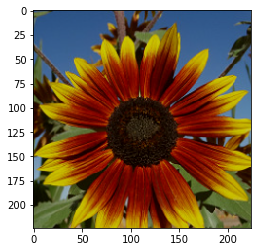

In [16]:
image_batch, label_batch = next(itr)
img = image_batch[0]
plt.imshow(img)
print(label_batch[0])

**Note:** It may take a 4-5 minutes to see result of different batches. 


## MobileNetV2

These flower photos are much larger than handwritting recognition images in MNIST. They are about 10 times as many pixels per axis **and** there are three color channels, making the information here over 200 times larger!

How do our current techniques stand up? Copy your best model architecture over from the <a href="2_mnist_models.ipynb">MNIST models lab</a> and see how well it does after training for 5 epochs of 50 steps.

**TODO 2.a** Copy over the most accurate model from 2_mnist_models.ipynb or build a new CNN Keras model.

In [17]:
eval_path = "gs://cloud-ml-data/img/flower_photos/eval_set.csv"
nclasses = len(CLASS_NAMES)
hidden_layer_1_neurons = 400
hidden_layer_2_neurons = 100
dropout_rate = 0.25
num_filters_1 = 64
kernel_size_1 = 3
pooling_size_1 = 2
num_filters_2 = 32
kernel_size_2 = 3
pooling_size_2 = 2

layers = [
    Conv2D(num_filters_1, kernel_size=kernel_size_1,
           activation='relu',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    MaxPooling2D(pooling_size_1),
    Conv2D(num_filters_2, kernel_size=kernel_size_2,
           activation='relu'),
    MaxPooling2D(pooling_size_2),
    Flatten(),
    Dense(hidden_layer_1_neurons, activation='relu'),
    Dense(hidden_layer_2_neurons, activation='relu'),
    Dropout(dropout_rate),
    Dense(nclasses),
    Softmax()
]

old_model = Sequential(layers)
old_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [18]:
old_model.fit_generator(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
5/5 [==============================] - 129s 26s/step - loss: 5.5070 - accuracy: 0.2062 - val_loss: 1.7545 - val_accuracy: 0.2955
Epoch 2/5
5/5 [==============================] - 28s 6s/step - loss: 1.6313 - accuracy: 0.2438 - val_loss: 1.6078 - val_accuracy: 0.3324
Epoch 3/5
5/5 [==============================] - 31s 6s/step - loss: 1.6116 - accuracy: 0.1813 - val_loss: 1.6093 - val_accuracy: 0.1875
Epoch 4/5
5/5 [==============================] - 30s 6s/step - loss: 1.6094 - accuracy: 0.2062 - val_loss: 1.6093 - val_accuracy: 0.1875
Epoch 5/5
5/5 [==============================] - 31s 6s/step - loss: 1.6095 - accuracy: 0.2500 - val_loss: 1.6092 - val_accuracy: 0.1875


If your model is like mine, it learns a little bit, slightly better then random, but *ugh*, it's too slow! With a batch size of 32, 5 epochs of 5 steps is only getting through about a quarter of our images. Not to mention, this is a much larger problem then MNIST, so wouldn't we need a larger model? But how big do we need to make it?

Enter Transfer Learning. Why not take advantage of someone else's hard work? We can take the layers of a model that's been trained on a similar problem to ours and splice it into our own model.

[Tensorflow Hub](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-others,image-style-transfer,image-rnn-agent) is a database of models, many of which can be used for Transfer Learning. We'll use a model called [MobileNet](https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/4) which is an architecture optimized for image classification on mobile devices, which can be done with [TensorFlow Lite](https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb). Let's compare how a model trained on [ImageNet](http://www.image-net.org/) data compares to one built from scratch.

The `tensorflow_hub` python package has a function to include a Hub model as a [layer in Keras](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). We'll set the weights of this model as un-trainable. Even though this is a compressed version of full scale image classification models, it still has over four hundred thousand paramaters! Training all these would not only add to our computation, but it is also prone to over-fitting. We'll add some L2 regularization and Dropout to prevent that from happening to our trainable weights.

**TODO 2.b**: Add a Hub Keras Layer at the top of the model using the handle provided.

In [22]:
module_selection = "mobilenet_v2_100_224"
module_handle = "https://tfhub.dev/google/imagenet/{}/feature_vector/4" \
    .format(module_selection)

transfer_model = tf.keras.Sequential([
    hub.KerasLayer(module_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        nclasses,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
transfer_model.build((None,)+(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Even though we're only adding one more `Dense` layer in order to get the probabilities for each of the 5 flower types, we end up with over six thousand parameters to train ourselves. Wow!

Moment of truth. Let's compile this new model and see how it compares to our MNIST architecture.

In [23]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [24]:
transfer_model.fit(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS
)

Train for 5 steps, validate for 11 steps
Epoch 1/5
5/5 [==============================] - 71s 14s/step - loss: 2.0923 - accuracy: 0.2188 - val_loss: 1.7862 - val_accuracy: 0.2188
Epoch 2/5
5/5 [==============================] - 18s 4s/step - loss: 1.7001 - accuracy: 0.3125 - val_loss: 1.5405 - val_accuracy: 0.3580
Epoch 3/5
5/5 [==============================] - 18s 4s/step - loss: 1.3568 - accuracy: 0.4375 - val_loss: 1.2384 - val_accuracy: 0.5085
Epoch 4/5
5/5 [==============================] - 18s 4s/step - loss: 1.2952 - accuracy: 0.4875 - val_loss: 1.0852 - val_accuracy: 0.6023
Epoch 5/5
5/5 [==============================] - 19s 4s/step - loss: 0.9713 - accuracy: 0.6625 - val_loss: 0.9620 - val_accuracy: 0.6648


Alright, looking better!

Still, there's clear room to improve. Data bottlenecks are especially prevalent with image data due to the size of the image files. There's much to consider such as the computation of augmenting images and the bandwidth to transfer images between machines.

Think life is too short, and there has to be a better way? In the next lab, we'll blast away these problems by developing a cloud strategy to train with TPUs!

## Bonus Exercise

Keras has a [local way](https://keras.io/models/sequential/) to do distributed training, but we'll be using a different technique in the next lab. Want to give the local way a try? Check out this excellent [blog post](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) to get started. Or want to go full-blown Keras? It also has a number of [pre-trained models](https://keras.io/applications/) ready to use.

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.